# <span style="color:#0b486b">  Introduction to Deep Learning Workshop (2023)</span>

***
*Speaker:*  **Dr Lim Chern Hong** \[lim.chernhong@monash.edu\]
<br/>

***


# <span style="color:#ec8428">Part 2: Convolutional Neural Network (CNN)</span>
**This handson aims to implement a simple CNN architecture to perform character and object classification using the real-world dataset named `mnist` and `CIFAR-10`**

The simple Convolutional Neural Networks architecture is using the following configurations:
1. All CONV layers in the network using only **3×3** filters.
2. Stacking multiple CONV $\rightarrow$ RELU layer sets before applying a POOL operation (where the number of consecutive CONV $\rightarrow$  RELU layers normally increases as the network goes deeper).

---

## <span style="color:#ec8428">I. Simple CNN for the Mnist dataset (Gray scale image) classification</span> ##

In order to implement a full classification model, we need to follow the supervised machine learning pipeline.
The standard process of a supervised deep learning model is described as follows:

**Step 1: Data loading and processing**
   - Load the dataset and split into train, valid, and test sets.  

**Step 2: Implementation of CNN architecture**
   - Define the CNN model and construct the corresponding computational graph.
   - Define the loss function and the relevant measures of performance of interest (accuracy).
    
**Step 3: Training and evaluation**
   - Train the model using mini-batches from the train set by minimizing the loss function with an optimizer.
   - Predict on the test set and access its performance.

#### <span style="color:#ec8428">Step 1: Data loading and processing </span>

We first import the necessary packages and modules and load the MNIST dataset from tensorflow keras: https://www.tensorflow.org/api_docs/python/tf/keras/datasets

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, models, layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(123)
tf.random.set_seed(123)

(X_train_full, y_train_full) , (X_test_full, y_test_full) = datasets.mnist.load_data()
X_train_full, X_test_full = X_train_full/255.0, X_test_full/255.0
print(X_train_full.shape, y_train_full.shape)
print(X_test_full.shape, y_test_full.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


Since we have limited time and computing resources, instead of using all data to train, we reduce it to 10 times smaller dataset compare to the original one:

Training data: 6000
Validation data: 1000
Testing data: 1000

In [2]:
# Shuffle the dataset
train_val_idx = np.random.permutation(X_train_full.shape[0])
test_idx = np.random.permutation(X_test_full.shape[0])

n_train, n_valid, n_test = 6000, 1000, 1000
X_train, y_train = X_train_full[train_val_idx][:n_train], y_train_full[train_val_idx][:n_train]
X_valid, y_valid = X_train_full[train_val_idx][n_train:n_train+n_valid], y_train_full[train_val_idx][n_train:n_train+n_valid]
X_test, y_test = X_test_full[test_idx][:n_test], y_test_full[test_idx][:n_test]
y_train = y_train.reshape(-1)
y_valid = y_valid.reshape(-1)
y_test = y_test.reshape(-1)
print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_valid.shape, y_valid.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (6000, 28, 28) (6000,)
Validation set (1000, 28, 28) (1000,)
Test set (1000, 28, 28) (1000,)


Following code show some samples of the mnist dataset

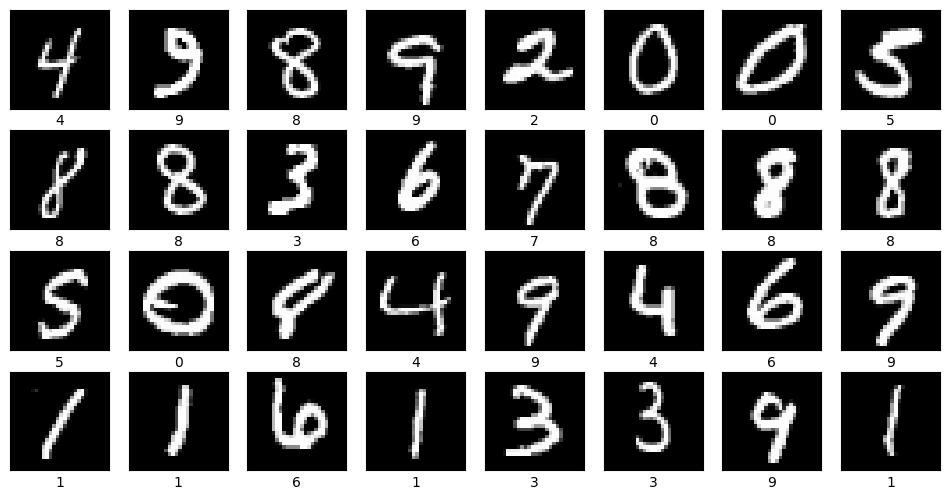

In [3]:
import math
def visualize_data(images, categories, images_per_row = 8):
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i],cmap='gray')
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

visualize_data(X_train[0:32], y_train[0:32])

#### <span style="color:#ec8428">Step 2: Implementation of CNN architecture </span>

We are going to implement the CNN architecrure as follow:

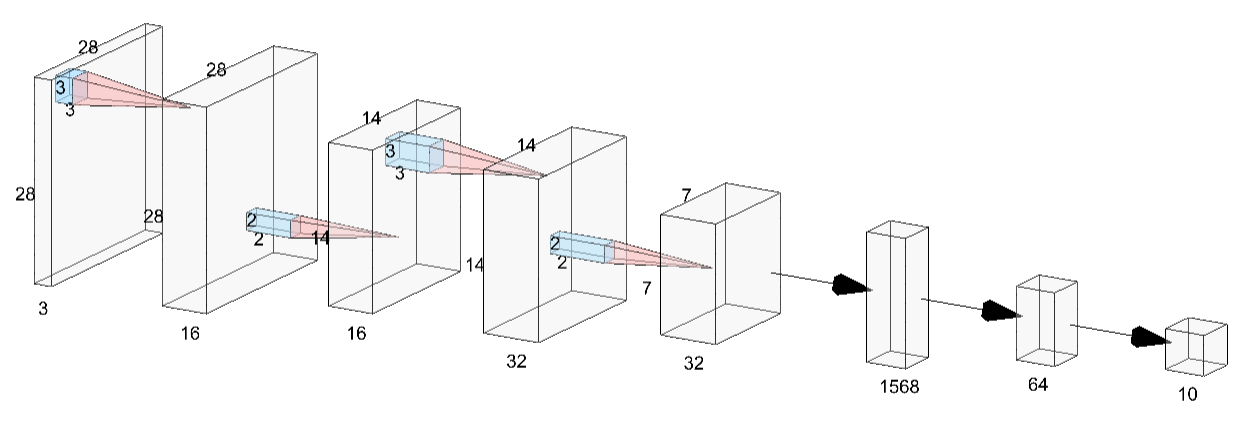

The architecture consists of:

1) input with size 28x28x1 (depth =1 because we are using grayscale image)

2) 1st Convolution layer with 16 3x3 filters, activation function=ReLU

3) Max pooling layer

4) 2nd Convolution layer with 32 3x3 filters, activation function=ReLU

5) Max pooling layer

6) Flatten layer (to resize the output of the pooling to 1D vector)

7) Fully connected hidden layer with 64 neurons, activation function=ReLU

8) Fully connected layer with 10 neurons (output), activation function=Softmax

*Batch normalization and dropout are optional layers


In [4]:
def my_cnn():
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(28,28,1)))
#     cnn_model.add(layers.BatchNormalization(momentum=0.9)) #Optional
    cnn_model.add(layers.MaxPool2D(pool_size=(2,2)))  #downscale the image size by 2
#     cnn_model.add(layers.Dropout(rate=0.25))  #deactivate 25% of neurons for each feed-forward
    cnn_model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
#     cnn_model.add(layers.BatchNormalization(momentum=0.9)) #Optional
    cnn_model.add(layers.MaxPool2D(pool_size=(2,2)))  #downscale the image size by 2
#     cnn_model.add(layers.Dropout(rate=0.25))  #deactivate 25% of neurons for each feed-forward
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dense(64, activation='relu'))
    cnn_model.add(layers.Dense(10, activation='softmax')) #ten classes in MNIST
    return cnn_model

cnn = my_cnn()
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 64)                1

#### <span style="color:#ec8428">Step 3: Training and evaluation </span>

In [5]:
opt = keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = cnn.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid))

test_loss, test_acc = cnn.evaluate(X_test,  y_test, verbose=1, batch_size=32)
print("Test acc is {}".format(test_acc))

Epoch 1/5
188/188 [==============================] - 14s 60ms/step - loss: 0.6676 - accuracy: 0.7923 - val_loss: 0.3162 - val_accuracy: 0.9080
Epoch 2/5
188/188 [==============================] - 9s 49ms/step - loss: 0.1930 - accuracy: 0.9360 - val_loss: 0.1721 - val_accuracy: 0.9580
Epoch 3/5
188/188 [==============================] - 7s 36ms/step - loss: 0.1173 - accuracy: 0.9613 - val_loss: 0.1663 - val_accuracy: 0.9610
Epoch 4/5
188/188 [==============================] - 4s 22ms/step - loss: 0.0869 - accuracy: 0.9718 - val_loss: 0.1369 - val_accuracy: 0.9600
Epoch 5/5
32/32 [==============================] - 0s 7ms/step - loss: 0.0832 - accuracy: 0.9790
Test acc is 0.9789999723434448


Plot the result

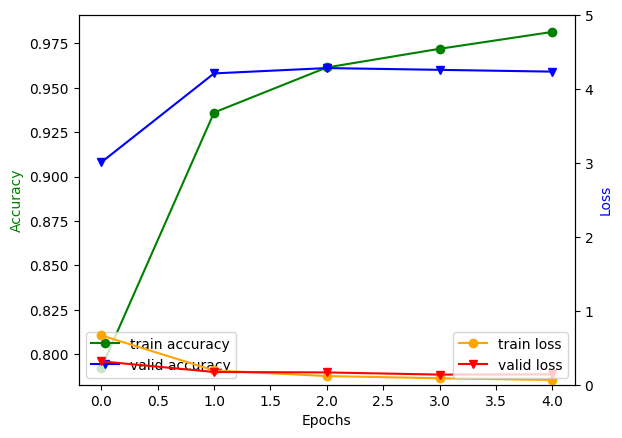

In [6]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(history.history['accuracy'], label='train accuracy', color='green', marker="o")
ax1.plot(history.history['val_accuracy'], label='valid accuracy', color='blue', marker = "v")
ax2.plot(history.history['loss'], label = 'train loss', color='orange', marker="o")
ax2.plot(history.history['val_loss'], label = 'valid loss', color='red', marker = "v")
ax1.legend(loc=3)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('Loss', color='b')
ax2.legend(loc=4)
plt.ylim([0.0, 5])
plt.show()

## <span style="color:#ec8428">II. Using Pretrained CNN Network for the CIFAR-10 dataset (color image) classification (Transfer learning)</span> ##

### <span style="color:#ec8428">Variant of CNN and tensorflow dataset</span>
Variants of tensorflow available CNN network: https://www.tensorflow.org/api_docs/python/tf/keras/applications

List of dataset available in tensorflow datasets: https://www.tensorflow.org/datasets/catalog/overview#all_datasets

We will use *tensorflow_datasets* to download and store the CIFAR-10 dataset on the hard disk, we need first to install this module using pip. Please activate your TensorFlow environment and install the package *tensorflow_datasets* using:
- > <span style="color:red"> pip install tensorflow_datasets </span>

### <span style="color:#ec8428">Implementation using VGG16 architecture </span>

#### <span style="color:#ec8428">Step 1: Import necessary packages and modules </span>

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, models, layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(123)
tf.random.set_seed(123)

#### <span style="color:#ec8428">Step 2: Download, prepare and preprocess CIFAR-10 dataset </span>

The CIFAR-10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [8]:
(X_train_full, y_train_full) , (X_test_full, y_test_full) = datasets.cifar10.load_data()
X_train_full, X_test_full = X_train_full/255.0, X_test_full/255.0
print(X_train_full.shape, y_train_full.shape)
print(X_test_full.shape, y_test_full.shape)

170498071/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


First, we need to shuffle the entire dataset.

In [9]:
train_val_idx = np.random.permutation(X_train_full.shape[0])
test_idx = np.random.permutation(X_test_full.shape[0])

Create a tiny `CIFAR-10` for a demonstration.

In [10]:
n_train, n_valid, n_test = 500, 100, 100
X_train, y_train = X_train_full[train_val_idx][:n_train], y_train_full[train_val_idx][:n_train]
X_valid, y_valid = X_train_full[train_val_idx][n_train:n_train+n_valid], y_train_full[train_val_idx][n_train:n_train+n_valid]
X_test, y_test = X_test_full[test_idx][:n_test], y_test_full[test_idx][:n_test]
y_train = y_train.reshape(-1)
y_valid = y_valid.reshape(-1)
y_test = y_test.reshape(-1)
print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_valid.shape, y_valid.shape)
print('Test set', X_test.shape, y_test.shape)

## Resizing images
X_train = tf.image.resize(X_train, (150, 150))
X_valid = tf.image.resize(X_valid, (150, 150))
X_test = tf.image.resize(X_test, (150, 150))
print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_valid.shape, y_valid.shape)
print('Test set', X_test.shape, y_test.shape)


Training set (500, 32, 32, 3) (500,)
Validation set (100, 32, 32, 3) (100,)
Test set (100, 32, 32, 3) (100,)
Training set (500, 150, 150, 3) (500,)
Validation set (100, 150, 150, 3) (100,)
Test set (100, 150, 150, 3) (100,)


#### <span style="color:#ec8428">Step 3: Visualize CIFAR-10 images </span>

In [11]:
import math
def visualize_data(images, categories, images_per_row = 8):
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

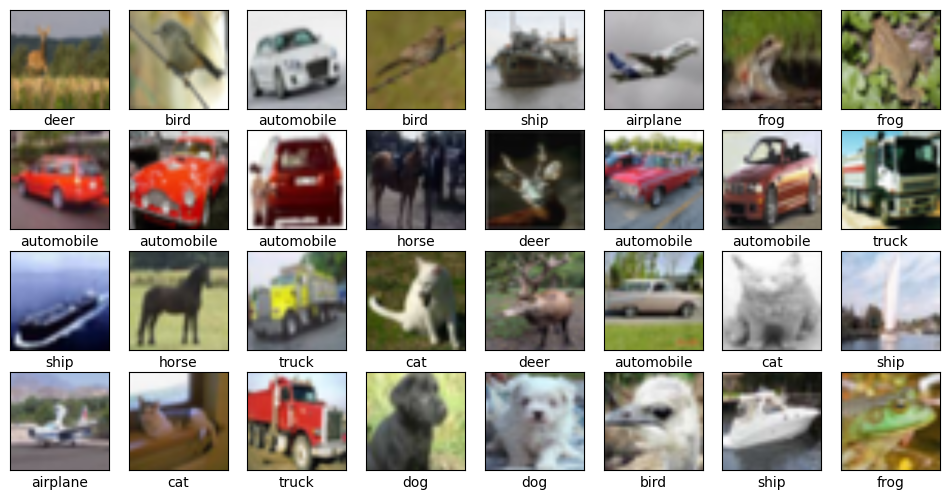

In [12]:
visualize_data(X_train[0:32], y_train[0:32])

#### <span style="color:#ec8428">Step 4: load the VGG16 network as base_model network </span>

In transfer learning, we first freeze the convolution parts by setting base-model.trainable to false. This is with the purpose to warm up the base model with the new head (dense layer). Note that the base model is pre-trained with the imagenet, so we load the weights="imagenet".

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [15]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(20, activation='relu')
dense_layer_2 = layers.Dense(15, activation='relu')
prediction_layer = layers.Dense(10, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])


In [16]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
16/16 [==============================] - 176s 11s/step - loss: 2.3142 - accuracy: 0.1160 - val_loss: 2.3453 - val_accuracy: 0.0800
Epoch 2/10
16/16 [==============================] - 184s 12s/step - loss: 2.2353 - accuracy: 0.1360 - val_loss: 2.3515 - val_accuracy: 0.1000
Epoch 3/10
16/16 [==============================] - 176s 11s/step - loss: 2.1481 - accuracy: 0.1980 - val_loss: 2.1894 - val_accuracy: 0.1600
Epoch 4/10
16/16 [==============================] - 173s 11s/step - loss: 2.0121 - accuracy: 0.2360 - val_loss: 2.0753 - val_accuracy: 0.2700
Epoch 5/10
16/16 [==============================] - 174s 11s/step - loss: 1.9134 - accuracy: 0.3220 - val_loss: 2.0882 - val_accuracy: 0.3000
Epoch 6/10
16/16 [==============================] - 179s 11s/step - loss: 1.7946 - accuracy: 0.3560 - val_loss: 1.9829 - val_accuracy: 0.3400
Epoch 7/10
16/16 [==============================] - 175s 11s/step - loss: 1.6734 - accuracy: 0.4220 - val_loss: 1.9635 - val_accuracy: 0.3500
Epoch 

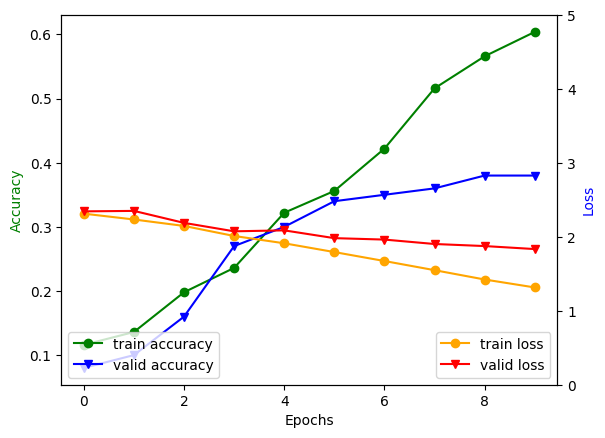

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(history.history['accuracy'], label='train accuracy', color='green', marker="o")
ax1.plot(history.history['val_accuracy'], label='valid accuracy', color='blue', marker = "v")
ax2.plot(history.history['loss'], label = 'train loss', color='orange', marker="o")
ax2.plot(history.history['val_loss'], label = 'valid loss', color='red', marker = "v")
ax1.legend(loc=3)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('Loss', color='b')
ax2.legend(loc=4)
plt.ylim([0.0, 5])
plt.show()

Once the warm up is done, we unfreeze the convolution part by setting base_model.trainable to True, so it will train the convolution part. It is possible to just train the last few layers of the convolution part as the first few layers are with primitive features that exist in all object. The intuition is to just update the model to understand the abstract of the new objects.

Can refer here for more details: https://www.tensorflow.org/tutorials/images/transfer_learning

In [18]:
base_model.trainable = True ## Not trainable weights
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
16/16 [==============================] - 159s 10s/step - loss: 1.2208 - accuracy: 0.6240 - val_loss: 1.8509 - val_accuracy: 0.3600
Epoch 2/10
16/16 [==============================] - 160s 10s/step - loss: 1.0699 - accuracy: 0.7040 - val_loss: 1.7379 - val_accuracy: 0.4000
Epoch 3/10
16/16 [==============================] - 176s 11s/step - loss: 1.0131 - accuracy: 0.7160 - val_loss: 1.9474 - val_accuracy: 0.3400
Epoch 4/10
16/16 [==============================] - 173s 11s/step - loss: 0.9057 - accuracy: 0.7640 - val_loss: 1.7039 - val_accuracy: 0.3800
Epoch 5/10
16/16 [==============================] - 176s 11s/step - loss: 0.8189 - accuracy: 0.7960 - val_loss: 1.7986 - val_accuracy: 0.3900
Epoch 6/10
16/16 [==============================] - 161s 10s/step - loss: 0.7338 - accuracy: 0.8260 - val_loss: 1.8015 - val_accuracy: 0.3900
Epoch 7/10
16/16 [==============================] - 176s 11s/step - loss: 0.6699 - accuracy: 0.8600 - val_loss: 1.8182 - val_accuracy: 0.4000
Epoch 

The result plotting is as follow.

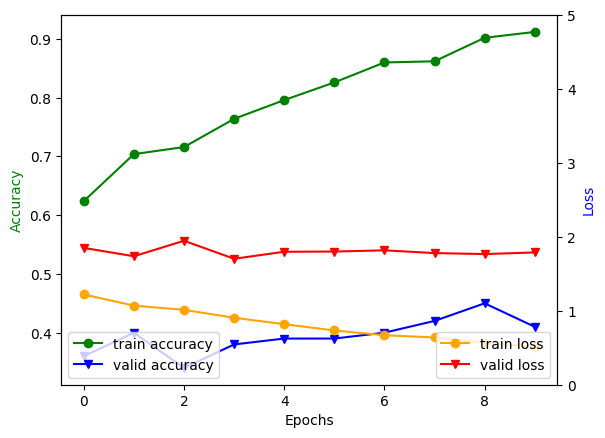

In [19]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(history.history['accuracy'], label='train accuracy', color='green', marker="o")
ax1.plot(history.history['val_accuracy'], label='valid accuracy', color='blue', marker = "v")
ax2.plot(history.history['loss'], label = 'train loss', color='orange', marker="o")
ax2.plot(history.history['val_loss'], label = 'valid loss', color='red', marker = "v")
ax1.legend(loc=3)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('Loss', color='b')
ax2.legend(loc=4)
plt.ylim([0.0, 5])
plt.show()

### <span style="color:#ec8428"> Try it yourself </span>

**<span style="color:red">Exercise 1:</span>** Retrain the simple CNN (my_cnn) model with batch_norm and dropout layers and observe the training progress result.

**<span style="color:red">Exercise 2:</span>** Change the hyper-parameters such as number of epochs, and batch size, or add in extra CNN layers and observe the training progress and results.